Construct a GMOT:

In [26]:
from MOTorNOT.gmot import gratingMOT
from MOTorNOT.coils import QuadrupoleCoils
import numpy as np

coils = QuadrupoleCoils(radius=0.1, offset=0.1, turns=50, current=50, axis=2, deltaI=27)
linewidth = 2*np.pi*29e6

gmot = gratingMOT(position = 3e-3, 
                  alpha = 60, 
                  detuning = -linewidth/2, 
                  radius = 10e-3, 
                  power = 20e-3, 
                  handedness = -1, 
                  R1 = 0.25, 
                  field = coils.field,
                  sectors=4,
                  beam_type='gaussian',
                  grating_radius=10e-3)
gmot.plot('yz', limits=[(-12e-3, 12e-3), (-3e-3, 4e-3)], numpoints=80, quiver_scale=5)

What if the diffraction efficiency is too high, pushing the potential minimum upwards? We can compensate with a coil current imbalance. To determine the necessary imbalance, we can calculate the force vs $z$ at $x=y=0$ and find the location of the trap zero:

-0.001878787878787879

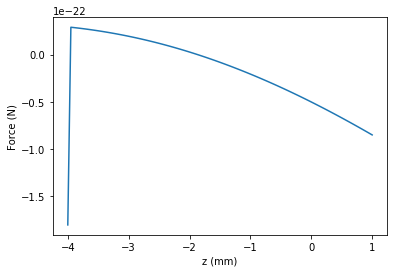

In [19]:
import matplotlib.pyplot as plt


def calculate_zero(R1, plot=False, deltaI=0):
    coils = QuadrupoleCoils(radius=0.1, offset=0.1, turns=50, current=50, axis=2, deltaI=deltaI)
    gmot = gratingMOT(position = 4e-3, 
                      alpha = 60, 
                      detuning = -2*linewidth, 
                      radius = 20e-3, 
                      power = 20e-3, 
                      handedness = -1, 
                      R1 = R1, 
                      field = coils.field,
                      sectors=4,
                      beam_type='gaussian',
                      grating_radius=10e-3)
    X = np.zeros((100, 3))
    V = np.zeros(X.shape)

    z = np.linspace(-4e-3, 1e-3, X.shape[0])
    X[:, 2] = z
    fz = gmot.force(X, V)[:, 2]

    if plot:
        plt.plot(z*1000, fz)
        plt.xlabel('z (mm)')
        plt.ylabel('Force (N)')

    zero = z[np.argmin(np.abs(fz))]
    return zero

calculate_zero(0.25, plot=True)

Now we'll study the zero offset vs. diffraction efficiency:

Text(0, 0.5, 'Zero offset (mm)')

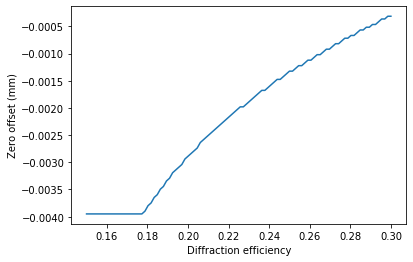

In [13]:
R1 = np.linspace(0.15, 0.3, 100)
zero = []
for r in R1:
    zero.append(calculate_zero(r, deltaI=0))
    
plt.plot(R1, zero)
plt.xlabel('Diffraction efficiency')
plt.ylabel('Zero offset (mm)')

Let's visualize this in 2D: just how much of an imbalance can we compensate with a quadrupole offset?

In [20]:
numpoints = 80
R1 = np.linspace(0.1, 0.43, numpoints)
deltaI = np.linspace(-30, 50, numpoints)

pairs = np.transpose(np.meshgrid(R1, deltaI)).reshape(-1, 2)
result = []
for pair in pairs:
    result = np.append(result, calculate_zero(pair[0], deltaI=pair[1]))

import plotly.graph_objs as go
fig = go.Figure([go.Heatmap(x=R1, y=deltaI, z=result.reshape(numpoints, numpoints).T, 
                            colorscale='Viridis', 
                            colorbar={'title': 'Trap offset (mm)', 'titleside': 'right'})])
fig.update_layout(
    xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text='Diffraction efficiency')),
    yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text='Current differential (A)'))
    )
fig.show() 